In [1]:
###libs
import os
import argparse
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2 
###files
from config import Config as cfg
from dataProcessing import VOC_dataset as dataset
from models.network import NetAPI
from trainer import Trainer
from utils import tensor_to_img


In [2]:
def draw_bboxes(img,bboxes,color,th=1):
    img_ = img.copy()
    for bbox in bboxes:
        x,y,w,h = bbox
        pt1 = (int(x-w/2),int(y-h/2))
        pt2 = (int(x+w/2),int(y+h/2))
        img_ =cv2.rectangle(img_,pt1,pt2,color,thickness = th)
    return img_
def draw_bboxes_wt_text(img,bboxes,color,th=1):
    img_ = img.copy()
    for bbox in bboxes:
        x,y,w,h = bbox
        pt1 = (int(x-w/2),int(y-h/2))
        pt2 = (int(x+w/2),int(y+h/2))
        img_ =cv2.rectangle(img_,pt1,pt2,color,thickness = th)
    return img_

In [3]:
exp = 'visual'
resume = 'best'
net = 'yolo_spp'

In [4]:
config  = cfg(mode='val')
val_set = dataset(config)
val_set = dataset(config,mode='val')
val_bs = 2
val_loader = DataLoader(val_set,batch_size=val_bs,shuffle=False,pin_memory=False,collate_fn=val_set.collate_fn)
datasets = {'val':val_loader}

config.device = torch.device("cuda")
torch.cuda.empty_cache()
#for reproducity
torch.manual_seed(2333)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [6]:
network = NetAPI(config,net,'yolo',init=False)


In [7]:
config.exp_name = exp
det = Trainer(config,datasets,network,(resume,-1))

load:../checkpoints/visual/epoch_best.pt


In [8]:
imgs,pds,gts,sizes = det.validate_random()
print(imgs[0].shape)

torch.Size([3, 416, 416])


torch.Size([27, 7])
tensor([[  8.0000, 293.5000, 275.0000,  61.0000, 128.0000],
        [  8.0000, 209.0000, 318.0000,  88.0000, 108.0000],
        [  8.0000,  36.0000, 309.0000,  62.0000, 130.0000],
        [  8.0000, 268.0000, 246.5000,  54.0000, 105.0000],
        [  8.0000, 294.5000, 203.0000,  35.0000,  34.0000]])
torch.Size([2, 7])
tensor([[  6.0000, 320.5000, 190.0000, 359.0000, 280.0000]])


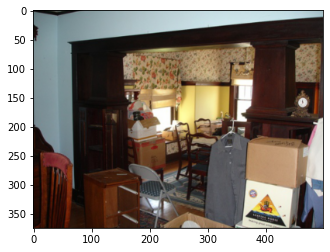

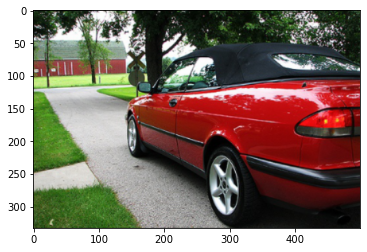

In [14]:
for b in range(val_bs):
    pd = pds[b]
    gt = gts[b]
    h,w = sizes[b]
    img = tensor_to_img(imgs[b])
    tsize = max(h,w)
    diff = (tsize-h,tsize-w)
    pad = (diff[0]//2,diff[1]//2,diff[0]-diff[0]//2,diff[1]-diff[1]//2)
    img = cv2.resize(img,(tsize,tsize))
    img = img[pad[0]:(tsize-pad[2]),pad[1]:(tsize-pad[3])]
    print(pd.shape)
    print(gt)
    plt.figure()
    plt.imshow(img)